# Adição do Campo Indexação no Modelo FrontBack

Nesse notebook será avaliada a influência do campo 'Indexação', presente em alguns dos acórdãos do STF, na eficácia do modelo FrontBack para classificação de acórdãos dentre os ramos do direito.

Para isso, será carregado o modelo FrontBack, já treinado com os dados das ementas de treinamento, e nele serão injetados os dados de indexação válidos e processados para que ele possa ser novamente treinado e avaliado.


Para isso, será feito um treinamento de modelo com aproximação FrontBack juntando os textos das ementas junto com os textos das indexações. Por fim é feita uma pequena avaliação do modelo baseada em métricas básicas.

## Inicialização e definiçao de constantes

Como uma etapa inicial, toda a inicialização do notebook será concentrada no início desse documento. Os conteúdos contidos aqui são:

1. Instalação de bibliotecas externas
2. Importação de biblioteca
3. Definição de valores constantes que podem ter seu uso replicado ao longo do notebook
4. Inicialização do sistema de arquivos integrado ao Google Drive

In [1]:
# Installation of 3rd party libraries

!pip install transformers
!pip install --upgrade pytorch-lightning

     |████████████████████████████████| 3.1 MB 5.4 MB/s 
     |████████████████████████████████| 3.3 MB 30.7 MB/s 
     |████████████████████████████████| 895 kB 1.3 MB/s 
     |████████████████████████████████| 59 kB 6.8 MB/s 
     |████████████████████████████████| 596 kB 44.5 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
     |████████████████████████████████| 523 kB 5.3 MB/s 
     |████████████████████████████████| 132 kB 46.9 MB/s 
     |████████████████████████████████| 329 kB 41.6 MB/s 
     |████████████████████████████████| 829 kB 35.5 MB/s 
     |████████████████████████████████| 1.1 MB 26.1 MB/s 
     |████████████████████████████████| 192 kB 33.6 MB/s 
     |████████████████████████████████| 271 kB 48.2 MB/s 
     |████████████████████████████████| 160 kB 36.5 MB/s 
  Created wheel for future: filename=future-0.18.2-py3-none-any.whl size=491070 sha256=bc359a4a65621a0

In [2]:
# Imports

from google.colab import drive
import pandas as pd
import numpy as np
from transformers import BertTokenizerFast as BertTokenizer, BertModel, BertForSequenceClassification, AdamW, get_cosine_schedule_with_warmup, Trainer, TrainingArguments
from enum import Enum
from typing import List
from itertools import islice
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, TensorDataset, SequentialSampler
import re
import pytorch_lightning as pl
from pytorch_lightning import seed_everything
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, cohen_kappa_score, matthews_corrcoef, balanced_accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Constants

CONSTANTS = {
    'TRAINING_DATASET': '/content/drive/My Drive/MAC499 - Kaique e Yurick/DB/Train_Dataset.csv',
    'VALIDATION_DATASET': '/content/drive/My Drive/MAC499 - Kaique e Yurick/DB/Validation_Dataset.csv',
    'TEST_DATASET': '/content/drive/My Drive/MAC499 - Kaique e Yurick/DB/Test_Dataset.csv',
    'BERT_MODEL_NAME': 'neuralmind/bert-large-portuguese-cased',
    'SEED': 13,
    'MODEL_PATH': '/content/drive/My Drive/MAC499 - Kaique e Yurick/Projeto/saved_models/frontback_finetuned_1.bin'
}

# Hyperparameters

HYPERPARAMETERS = {
    'BATCH_SIZE': 2,
    'EPOCHS': 3,
    'MAX_NUMBER_TOKENS': 512,
    'LEARNING_RATE': 2e-5,
    'NUMBER_OF_BRANCHES': 13,
    'WEIGHT_DECAY': 0.001,
    'WARM_UP_PROPORTION': 0.1,
    'INTRODUCTION_WORDS': 256
}

In [4]:
# Mounting Google Drive

drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


## Verificar disponibilidade da GPU

O próximo passo seria verificar se a GPU oferida pela Google gratuitamente como ambiente de execução do notebook está funcionando corretamente. A GPU oferece uma performance computacional maior em relação a calculos sendo executados pela CPU.

In [5]:
torch.cuda.empty_cache()

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla K80


### Reproducibilidade

Para fins de reproducibilidade, podemos definir uma semente para o pytorch lightning.

In [6]:
seed_everything(CONSTANTS['SEED'])

Global seed set to 13


13

## Carregar os dados

Após as configurações iniciais, os dados são carregados da mesma forma que no notebook de criação e treinamento do modelo FrontBack.

Assim, nessa etapa são carregados arquivos .csv contendo os conjuntos de treinamento e de validação.

In [7]:
# Read the training dataset from .csv file
documents = pd.read_csv(CONSTANTS['TRAINING_DATASET'])
# Read the validation dataset from .csv file
documents_val = pd.read_csv(CONSTANTS['VALIDATION_DATASET'])

In [8]:
def get_words(sentence: str) -> List[str]:
    """Retrieves the words in a sentence by splitting into blank spaces.

    Args:
        sentence (str): a sentence.

    Returns:
        List[str]: list of words in sentence.
    """
    return re.findall(r'\S+', sentence)

def merge_front_back_summary(full_summary: str, max_summary_size: int) -> str:
    """Extracts the part of the front and part of the back from the summary,
    following the properties defined in Constants structure.

    Args:
        full_summary (str): the entire summary content.
        max_summary_size (int): the max number of tokens considered.

    Returns:
        str: a version of summary with the beginning of its front and the end
        of its back.
    """
    front_size = HYPERPARAMETERS['INTRODUCTION_WORDS']
    back_size = max_summary_size - front_size

    summary_words = get_words(full_summary)

    if (len(summary_words) <= max_summary_size):
        return full_summary

    front_summary = summary_words[:front_size]
    back_summary = summary_words[(len(summary_words) - back_size):]

    return ' '.join(front_summary).strip() + ' ' + ' '.join(back_summary).strip()

In [9]:
# Training dataset: Change column containing summary to considers front and back of it
documents['ementa'] = documents['ementa'].apply(lambda summary: merge_front_back_summary(summary, HYPERPARAMETERS['MAX_NUMBER_TOKENS']))
documents = documents.iloc[: , 1:]

In [10]:
# Validation dataset: Change column containing summary to considers front and back of it
documents_val['ementa'] = documents_val['ementa'].apply(lambda summary: merge_front_back_summary(summary, HYPERPARAMETERS['MAX_NUMBER_TOKENS']))
documents_val = documents_val.iloc[: , 1:]

O objetivo desse notebook é a utilização dos dados presentes no campo 'Indexação' dos acórdãos, o que não foi feito no notebook de criação do modelo Truncated. Portanto, é preciso pré-processar os valores de indexação para poder alimentá-los ao modelo.

O pré-processamento consiste de duas partes:
primeiro é feita uma transformação dos valores de indexação em textos, a remoção de alguns caracteres especiais dos textos de indexação e uma contagem da frequência dos termos de indexação para que seja feita uma identificação de termos que são muito presentes mas que não agregam na inferência do ramo do acórdão como 'VIDE EMENTA' e 'AGUARDANDO INDEXAÇÃO'. Após isso é feita a remoção desses termos identificados e criados novos dataframes (de treino e de validação) contendo apenas os valores de indexação processados e seus respectivos valores de classificação entre os ramos.

In [11]:
indexes = []
for i, index in enumerate(documents['indexacao'].tolist()):
  x1 = re.sub('[\]\[\']', '', index)
  x = re.sub('[:]', ',', x1)
  if x != '':
    for tmp in x.split(','):
      indexes.append(tmp.strip())
for i, index in enumerate(documents_val['indexacao'].tolist()):
  x = re.sub('[\]\[\']', '', index)
  if x != '':
    for tmp in x.split(','):
      indexes.append(tmp.strip())

freq = {}
for item in indexes:
  if item in freq:
    freq[item] += 1
  else:
    freq[item] = 1

sorted_items = sorted(freq.items(), key=lambda x: x[1], reverse=True)
sorted_items

[('MIN', 3651),
 ('AUSÊNCIA', 2747),
 ('VIDE EMENTA', 1949),
 ('VOTO VENCIDO', 1837),
 ('HIPÓTESE', 1777),
 ('DECORRÊNCIA', 1689),
 ('FUNDAMENTAÇÃO COMPLEMENTAR', 1460),
 ('NECESSIDADE', 1445),
 ('IMPOSSIBILIDADE', 1358),
 ('FUNDAMENTO', 1321),
 ('EXISTÊNCIA', 1306),
 ('POSSIBILIDADE', 1235),
 ('INEXISTÊNCIA', 1184),
 ('CARACTERIZAÇÃO', 1160),
 ('PREVISÃO', 1063),
 ('CONSTITUIÇÃO FEDERAL', 1006),
 ('OCORRÊNCIA', 958),
 ('CONFIGURAÇÃO', 941),
 ('MARCO AURÉLIO', 904),
 ('FINALIDADE', 885),
 ('OFENSA', 868),
 ('APLICAÇÃO', 813),
 ('DECISÃO', 793),
 ('DESCABIMENTO', 792),
 ('SUPREMO TRIBUNAL FEDERAL (STF)', 789),
 ('LEI', 763),
 ('COMPETÊNCIA', 746),
 ('ESTADO', 721),
 ('CONCESSÃO', 646),
 ('INOCORRÊNCIA', 603),
 ('JULGAMENTO', 599),
 ('ÂMBITO', 593),
 ('CASO CONCRETO', 581),
 ('OBJETIVO', 579),
 ('MEMBRO', 552),
 ('CRIME', 543),
 ('MATÉRIA', 542),
 ('OBSERVÂNCIA', 517),
 ('ENTENDIMENTO', 492),
 ('INCONSTITUCIONALIDADE', 486),
 ('PEDIDO', 476),
 ('MANDADO DE SEGURANÇA', 468),
 ('CONSIDERAÇ

Visualizando a lista de termos e suas frequências, é necessário fazer a remoção de uma lista relativamente extensa de termos dos textos da indexacao.

In [12]:
# Process the indexação column
ramos = []
indexes = []
for i, index in enumerate(documents['indexacao'].tolist()):
  x = re.sub('[\]\[\']', '', index)
  x = x.replace('VIDE EMENTA', '').replace('AGUARDANDO INDEXAÇÃO', '') \
    .replace('MIN', '').replace('VOTO VENCIDO', '') \
    .replace('SUPREMO TRIBUNAL FEDERAL (STF)', '') \
    .replace('STF', '') \
    .replace('DIREITO', '') \
    .replace('(STF)', '') \
    .replace('MARCO AURÉLIO', '') \
    .replace('QUESTÃO DE ORDEM: VOTO VENCIDO', '') \
    .replace('GILMAR MENDES', '') \
    .replace('LUIZ FUX', '') \
    .replace('AYRES BRITTO', '') \
    .replace('CELSO DE MELLO', '') \
    .replace('RICARDO LEWANDOWSKI', '') \
    .replace('ROBERTO BARROSO', '') \
    .replace('CEZAR PELUSO', '') \
    .replace('CARMEN LÚCIA', '') \
    .replace('DIAS TOFFOLI', '') \
    .replace('EDSON FACHIN', '') \
    .replace('ROSA WEBER', '') \
    .replace('JOAQUIM BARBOSA', '') \
    .replace('MINISTRO', '') \
    .replace('TEORI ZAVASCKI', '') \
    .replace('ALEXANDRE MORAES', '') \
    .replace('ELLEN GRACIE', '') \
    .replace('CARLOS VELLOSO', '') \
    .replace(':', ',') \
    .replace(', ,', ',') 
  x1 = re.sub('^, ,', '', x)
  if x1.strip() != '':
    indexes.append(x1)
    ramos.append(documents['ramo'][i])
documents_train = pd.DataFrame(list(zip(ramos, indexes)),
               columns = ['ramo', 'text'])
for row in documents.iterrows():
  tmp = pd.DataFrame({'ramo': [row[1].ramo], 'text': [row[1].ementa]})
  documents_train = pd.concat([documents_train, tmp], ignore_index = True, axis = 0)
documents_train

,ramo,text
0,1,"AUSÊNCIA, DECADÊNCIA ADISTRATIVA, ATO, APOSENT..."
1,1,"OCORRÊNCIA, CASO CONCRETO, AUMENTO, REMUNERAÇÃ..."
2,1,"CONSTITUCIONALIDADE, DISPOSITIVO, LEI ORGÂNICA..."
3,1,"DECLARAÇÃO, INCONSTITUCIONALIDADE, LEI ESTADUA..."
4,0,"NECESSIDADE, FUNDAMENTAÇÃO IDÔNEA, RECUSA, SUB..."
...,...,...
6555,2,EMENTA Recurso extraordinário – Emenda Constit...
6556,1,EMENTA: MANDADO DE SEGURANÇA. DECRETO HOMOLOGA...
6557,0,EMENTA: RECURSO ORDINÁRIO EM HABEAS-CORPUS. PR...
6558,1,Ementa: DIREITO CONSTITUCIONAL E ADMINISTRATIV...


In [13]:
# Process the indexação column on validation dataset
ramos_val = []
indexes_val = []
for i, index in enumerate(documents_val['indexacao'].tolist()):
  x = re.sub('[\]\[\']', '', index)
  x = x.replace('VIDE EMENTA', '').replace('AGUARDANDO INDEXAÇÃO', '') \
    .replace('MIN', '').replace('VOTO VENCIDO', '') \
    .replace('SUPREMO TRIBUNAL FEDERAL (STF)', '') \
    .replace('STF', '') \
    .replace('DIREITO', '') \
    .replace('(STF)', '') \
    .replace('MARCO AURÉLIO', '') \
    .replace('QUESTÃO DE ORDEM: VOTO VENCIDO', '') \
    .replace('GILMAR MENDES', '') \
    .replace('LUIZ FUX', '') \
    .replace('AYRES BRITTO', '') \
    .replace('CELSO DE MELLO', '') \
    .replace('RICARDO LEWANDOWSKI', '') \
    .replace('ROBERTO BARROSO', '') \
    .replace('CEZAR PELUSO', '') \
    .replace('CARMEN LÚCIA', '') \
    .replace('DIAS TOFFOLI', '') \
    .replace('EDSON FACHIN', '') \
    .replace('ROSA WEBER', '') \
    .replace('JOAQUIM BARBOSA', '') \
    .replace('MINISTRO', '') \
    .replace('TEORI ZAVASCKI', '') \
    .replace('ALEXANDRE MORAES', '') \
    .replace('ELLEN GRACIE', '') \
    .replace('CARLOS VELLOSO', '') \
    .replace(':', ',') \
    .replace(', ,', ',')
  x1 = re.sub('^, ,', '', x)
  if x1 != '':
    indexes_val.append(x1)
    ramos_val.append(documents_val['ramo'][i])
documents_validation = pd.DataFrame(list(zip(ramos_val, indexes_val)),
               columns = ['ramo', 'text'])
for row in documents_val.iterrows():
  tmp = pd.DataFrame({'ramo': [row[1].ramo], 'text': [row[1].ementa]})
  documents_validation = pd.concat([documents_validation, tmp], ignore_index = True, axis = 0)
documents_validation

,ramo,text
0,4,"DESEMBARGADOR, PREENCHIMENTO, REQUISITOS, CONC..."
1,0,"ADMISSÃO, IMPETRAÇÃO, INDEFERIMENTO, ORDEM"
2,9,"INSUBSISTÊNCIA, ALEGAÇÃO, OFENSA, PRINCÍPIO DO..."
3,0,"(CRIAL),"
4,1,"SOLUÇÃO, PROBLEMA, TRANSIÇÃO, MODELO CONSTITUC..."
...,...,...
1405,0,EMENTA: PENAL E PROCESSUAL PENAL. RECURSO ORDI...
1406,1,Ementa: CONSTITUCIONAL E ADMINISTRATIVO. MANDA...
1407,1,Ementa: DIREITO CONSTITUCIONAL. ADI. VINCULAÇÃ...
1408,0,Ementa: PETIÇÃO. AGRAVO REGIMENTAL. DENÚNCIA. ...


O treinamento do modelo nesse notebook segue o mesmo formato do notebook de criação do modelo FrontBack. Então é baixado o tokenizer e são definidas e criadas classes para Dataset, DataModule e pro modelo em si.

Por fim, o modelo FrontBack é carregado do Drive e é feito o treinamento novamente utilizando o dataframe contendo as indexações como input.

In [14]:
class LawDocumentDataset(Dataset):
  def __init__(self, dataframe: pd.DataFrame, tokenizer: BertTokenizer, max_token_length: int=512):
    self.dataframe = dataframe
    self.tokenizer = tokenizer
    self.max_token_length = max_token_length

  def __len__(self):
    return len(self.dataframe)

  def __getitem__(self, index: int):
    row = self.dataframe.iloc[index]
    summary_document = row.text
    law_branch_id = row.ramo

    encoding = self.tokenizer.encode_plus(
      summary_document,
      add_special_tokens=True,          # Add `[CLS]` and `[SEP]`
      max_length=self.max_token_length,
      return_token_type_ids=False,
      padding="max_length",
      truncation=True,                  # Truncate encoding to the max length
      return_attention_mask=True,       # Return attention mask
      return_tensors="pt"               # Return PyTorch tensor
    )

    labels = np.eye(HYPERPARAMETERS['NUMBER_OF_BRANCHES'])[law_branch_id]  # Return a list with zeros, except for index law_branch_id that assumes one

    return dict(
        summary_document=summary_document,
        input_ids=encoding["input_ids"].flatten(),
        attention_mask=encoding["attention_mask"].flatten(),
        labels=torch.FloatTensor(labels)
    )

In [15]:
tokenizer = BertTokenizer.from_pretrained(CONSTANTS['BERT_MODEL_NAME'])

Downloading:   0%|          | 0.00/205k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/155 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/648 [00:00<?, ?B/s]

In [16]:
train_dataset = LawDocumentDataset(documents_train, tokenizer, HYPERPARAMETERS['MAX_NUMBER_TOKENS'])
validation_dataset = LawDocumentDataset(documents_validation, tokenizer, HYPERPARAMETERS['MAX_NUMBER_TOKENS'])

In [17]:
class LawDocumentClassifier(pl.LightningModule):
    
    def __init__(self, number_classes: int, steps_per_epoch: int=None, epochs: int=None, learning_rate: float=2e-5, weight_decay: float=0.001, warm_up_proportion: float=0.1):
        super().__init__()
        
        self.model = BertForSequenceClassification.from_pretrained(
            "neuralmind/bert-large-portuguese-cased",
            num_labels=number_classes,                      # The number of output labels--2 for binary classification
            output_attentions=False,                        # Returns attention weights
            output_hidden_states=False                      # Returns all hidden states
        )
        self.steps_per_epoch = steps_per_epoch
        self.epochs = epochs
        self.learning_rate = learning_rate
        self.warm_up_proportion = warm_up_proportion
        self.weight_decay = weight_decay
        
    def forward(self, input_ids, attention_mask, labels=None):
        output = self.model(input_ids,
                            attention_mask=attention_mask,
                            labels=labels,
                            return_dict=True)
        
        return output.loss, output.logits
        
    def training_step(self, batch, batch_index):
        input_ids = batch["input_ids"]
        attention_mask = batch["attention_mask"]
        labels = batch["labels"]
        
        loss, outputs = self(input_ids, attention_mask, labels)
        
        self.log("train_loss", loss, prog_bar=True, logger=True)
        
        return {"loss": loss, "predictions": outputs, "labels": labels}

    def compute_metrics(self, eval_pred):
        logits, labels = eval_pred
        
        classification_predictions = self.convert_to_classification_labels(logits)
        classification_labels = self.convert_to_classification_labels(labels)

        metrics = {
            "validation_accuracy": accuracy_score(classification_labels, classification_predictions),
            "validation_balanced_accuracy": balanced_accuracy_score(classification_labels, classification_predictions),
            "validation_precision": precision_score(classification_labels, classification_predictions, average='weighted'),
            "validation_recall": recall_score(classification_labels, classification_predictions, average='weighted'),
            "validation_f1": f1_score(classification_labels, classification_predictions, average='weighted'),
            "validation_cohen_kappa": cohen_kappa_score(classification_labels, classification_predictions),
            "validation_matthews": matthews_corrcoef(classification_labels, classification_predictions)
        }

        return metrics
            
    def configure_optimizers(self):
        optimizer = AdamW(self.parameters(), lr=self.learning_rate, weight_decay=self.weight_decay)
        warmup_steps = int(self.steps_per_epoch * self.warm_up_proportion)
        total_steps = self.steps_per_epoch * self.epochs - warmup_steps

        scheduler = get_cosine_schedule_with_warmup(optimizer, warmup_steps, total_steps)
        
        return (optimizer, scheduler)

    def convert_to_classification_labels(self, classifications):
        formatted_classifications = []

        for classification in classifications:
            formatted_classifications.append(np.argmax(classification).flatten())

        return formatted_classifications

In [18]:
model = LawDocumentClassifier(
    HYPERPARAMETERS['NUMBER_OF_BRANCHES'],
    steps_per_epoch=len(documents_train) // HYPERPARAMETERS['BATCH_SIZE'],
    epochs=HYPERPARAMETERS['EPOCHS'],
    learning_rate=HYPERPARAMETERS['LEARNING_RATE'],
    weight_decay=HYPERPARAMETERS['WEIGHT_DECAY'],
    warm_up_proportion=HYPERPARAMETERS['WARM_UP_PROPORTION']
)

Downloading:   0%|          | 0.00/1.25G [00:00<?, ?B/s]

Some weights of the model checkpoint at neuralmind/bert-large-portuguese-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from th

In [19]:
training_args = TrainingArguments(
    "/content/drive/My Drive/MAC499 - Kaique e Yurick/Projeto/indexacao_trainer_output",
    num_train_epochs = HYPERPARAMETERS['EPOCHS'],
    evaluation_strategy = 'epoch',
    per_device_train_batch_size = HYPERPARAMETERS['BATCH_SIZE'],
    logging_steps = 30,
    save_strategy='epoch'
)

trainer = Trainer(
    model=model,
    args=training_args,
    compute_metrics=model.compute_metrics,
    train_dataset=train_dataset,
    eval_dataset=validation_dataset,
    optimizers=model.configure_optimizers()
)
trainer.train("/content/drive/My Drive/MAC499 - Kaique e Yurick/Projeto/indexacao_trainer_output/checkpoint-6560")

Loading model from /content/drive/My Drive/MAC499 - Kaique e Yurick/Projeto/indexacao_trainer_output/checkpoint-6560).
***** Running training *****
  Num examples = 6560
  Num Epochs = 3
  Instantaneous batch size per device = 2
  Total train batch size (w. parallel, distributed & accumulation) = 2
  Gradient Accumulation steps = 1
  Total optimization steps = 9840
  Continuing training from checkpoint, will skip to saved global_step
  Continuing training from epoch 2
  Continuing training from global step 6560
  Will skip the first 2 epochs then the first 0 batches in the first epoch. If this takes a lot of time, you can add the `--ignore_data_skip` flag to your launch command, but you will resume the training on data already seen by your model.


0it [00:00, ?it/s]

Epoch,Training Loss,Validation Loss,Validation Accuracy,Validation Balanced Accuracy,Validation Precision,Validation Recall,Validation F1,Validation Cohen Kappa,Validation Matthews
3,0.093800,0.095993,0.795745,0.422860,0.752798,0.795745,0.768282,0.720609,0.724267


***** Running Evaluation *****
  Num examples = 1410
  Batch size = 8
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Saving model checkpoint to /content/drive/My Drive/MAC499 - Kaique e Yurick/Projeto/indexacao_trainer_output/checkpoint-9840
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=9840, training_loss=0.031640781207782465, metrics={'train_runtime': 5470.3728, 'train_samples_per_second': 3.598, 'train_steps_per_second': 1.799, 'total_flos': 0.0, 'train_loss': 0.031640781207782465, 'epoch': 3.0})

In [20]:
validation_metrics = trainer.evaluate()
validation_metrics

***** Running Evaluation *****
  Num examples = 1410
  Batch size = 8


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'epoch': 3.0,
 'eval_loss': 0.09599313139915466,
 'eval_runtime': 317.1112,
 'eval_samples_per_second': 4.446,
 'eval_steps_per_second': 0.558,
 'eval_validation_accuracy': 0.7957446808510639,
 'eval_validation_balanced_accuracy': 0.42286014388765863,
 'eval_validation_cohen_kappa': 0.7206091996411292,
 'eval_validation_f1': 0.768281899867755,
 'eval_validation_matthews': 0.7242668682159297,
 'eval_validation_precision': 0.7527979964805,
 'eval_validation_recall': 0.7957446808510639}

In [21]:
torch.save(model.state_dict(), '/content/drive/My Drive/MAC499 - Kaique e Yurick/Projeto/saved_models/index_frontback_model.bin')

## Avaliação no Conjunto de Testes

Terminada a fase de treinamento do modelo, vamos avaliá-lo com os dados do conjunto de testes para poder compará-lo com o modelo FrontBack sem a adição do campo indexação.

O procedimento executado é o mesmo do notebook de métricas para comparação das diferentes aproximações de construção dos modelos: o conjunto de testes é carregado do Drive e os dados são tokenizados e depois classificados pelos modelos.

In [22]:
test_documents = pd.read_csv(CONSTANTS['TEST_DATASET'])
test_documents.dropna(inplace=True, subset=['cod_acordao'])

In [23]:
# Definition of mapping from law branch name to a numeric identifier

class LawBranch(Enum):
    """Mapping to a Law Branch and an identification. The enum also stores
    the law branch name in a free text form.
    """

    Penal = (0, "Direito Penal (Direito Processual Penal)")
    Administrativo = (1, "Direito Administrativo (Licitações, Contratos Administrativos, Servidores, Desapropriação, Tribunal de Contas, Improbidade, etc.)")
    Tributario = (2, "Direito Tributário/Direito Financeiro")
    Civil = (3, "Direito Civil (Direito Comercial/Direito de Família)")
    Previdenciario = (4, "Direito Previdenciário")
    Trabalho = (5, "Direito do Trabalho")
    Processual_Civil = (6, "Direito Processual Civil")
    Eleitoral = (7, "Direito Eleitoral")
    Consumidor = (8, "Direito do Consumidor")
    Internacional = (9, "Direito Internacional (Público ou Privado)")
    Militar = (10, "Direito Militar")
    Economico = (11, "Direito Econômico (Direito concorrencial e Agências Reguladoras Setoriais, Intervenção no Domínio Econômico)")
    Ambiental = (12, "Direito Ambiental")

    def get_identifier(self) -> int:
        """Retrieves the identifier number for this instance of LawBranch.

        Returns:
            int: identifier of this instance of LawBranch
        """
        return self.value[0]
    
    @staticmethod
    def get_all_names() -> List[str]:
      """Retrieves a list of all names defined in LawBranch enum.

        Returns:
          List[str]: the list of names.

      """
      names = []
      for law_branch in LawBranch:
        names.append(law_branch.name)
      return names

In [24]:
# Função para tokenizar as ementas
def tokenize(ementas):
  """
    @param    ementas (list): Array de ementas a serem tokenizadas.
    @return   dataloader (torch.utils.data.DataLoader): DataLoader com os dados das predições
  """
  input_ids = []
  attention_masks = []

  for ementa in ementas:
    encoded_dict = tokenizer.encode_plus(
        ementa,
        add_special_tokens = True,
        max_length = HYPERPARAMETERS['MAX_NUMBER_TOKENS'],
        padding = 'max_length',
        truncation = True,
        return_attention_mask = True,
        return_tensors = 'pt',
        return_token_type_ids=False,
    )
        
    input_ids.append(encoded_dict['input_ids'])
    attention_masks.append(encoded_dict['attention_mask'])

  input_ids = torch.cat(input_ids, dim=0)
  attention_masks = torch.cat(attention_masks, dim=0)

  prediction_data = TensorDataset(input_ids, attention_masks)
  prediction_sampler = SequentialSampler(prediction_data)
  return DataLoader(prediction_data, sampler=prediction_sampler, batch_size=HYPERPARAMETERS['BATCH_SIZE'])


# Função que chama o modelo para classificar os acórdãos
def classify(acordaos, model):
  """
    @param  acordaos (pd.DataFrame): Dataframe com os acórdãos a serem classificados.
    @param  model (transformers.BertModel): Modelo BERT pré-treinado a ser utilizado.
    @return classifications (dict): Dicionário com os acórdãos classificados e suas ementas.
  """
  classifications = {
      'True Label': [],
      'Predicted Label': [],
      'Ementa': []
  }

  for id, row in acordaos.iterrows():
    classifications['Ementa'].append(row['ementa'])
    classifications['True Label'].append(row['ramo'])
  prediction_dataloader = tokenize(classifications['Ementa'])
  
  model.eval()
  predictions = []
  for batch in prediction_dataloader:
    batch = tuple(t.to(device) for t in batch)
    
    b_input_ids, b_input_mask = batch

    with torch.no_grad():
        _, outputs_logits = model(b_input_ids, attention_mask=b_input_mask)

    logits = outputs_logits
    logits = logits.detach().cpu().numpy()    
    predictions.append(logits)

  for prediction_batch in predictions:
    predicted_labels = np.argmax(prediction_batch, axis=1).flatten()
    for prediction in predicted_labels:
        classifications['Predicted Label'].append(prediction)

  return classifications

In [25]:
frontback_model = LawDocumentClassifier(HYPERPARAMETERS['NUMBER_OF_BRANCHES'], len(documents) // HYPERPARAMETERS['BATCH_SIZE'], HYPERPARAMETERS['EPOCHS'], HYPERPARAMETERS['LEARNING_RATE'])
frontback_model.load_state_dict(torch.load(CONSTANTS['MODEL_PATH']))

loading configuration file https://huggingface.co/neuralmind/bert-large-portuguese-cased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/c534071830642050813fa94003dbf1234413b3f1d5dc66d259fbc82ff7d5fd59.c8340a82acfbbcd2dd960b86d2886ee120b21896ef0294150f0391918ae6ced5
Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "directionality": "bidi",
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 1024,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5",
    "6": "LABEL_6",
    "7": "LABEL_7",
    "8": "LABEL_8",
    "9": "LABEL_9",
    "10": "LABEL_10",
    "11": "LABEL_11",
    "12": "LABEL_12"
  },
  "initializer_range": 0.02,
  "intermediate_size": 4096,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_10": 10,
    "LABEL_11": 11,
    "LABEL_12": 12,


<All keys matched successfully>

In [26]:
model = LawDocumentClassifier(HYPERPARAMETERS['NUMBER_OF_BRANCHES'], len(documents_train) // HYPERPARAMETERS['BATCH_SIZE'], HYPERPARAMETERS['EPOCHS'], HYPERPARAMETERS['LEARNING_RATE'])
model.load_state_dict(torch.load('/content/drive/My Drive/MAC499 - Kaique e Yurick/Projeto/saved_models/index_frontback_model.bin'))

loading configuration file https://huggingface.co/neuralmind/bert-large-portuguese-cased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/c534071830642050813fa94003dbf1234413b3f1d5dc66d259fbc82ff7d5fd59.c8340a82acfbbcd2dd960b86d2886ee120b21896ef0294150f0391918ae6ced5
Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "directionality": "bidi",
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 1024,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5",
    "6": "LABEL_6",
    "7": "LABEL_7",
    "8": "LABEL_8",
    "9": "LABEL_9",
    "10": "LABEL_10",
    "11": "LABEL_11",
    "12": "LABEL_12"
  },
  "initializer_range": 0.02,
  "intermediate_size": 4096,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_10": 10,
    "LABEL_11": 11,
    "LABEL_12": 12,


<All keys matched successfully>

In [29]:
model.cuda()
index_classifications = classify(test_documents, model)
frontback_model.cuda()
frontback_classifications = classify(test_documents, frontback_model)

In [30]:
index_metrics = {
    "Average Accuracy": accuracy_score(index_classifications['True Label'], index_classifications['Predicted Label']),
    "Weighted Precision": precision_score(index_classifications['True Label'], index_classifications['Predicted Label'], average='weighted'),
    "Weighted Recall": recall_score(index_classifications['True Label'],index_classifications['Predicted Label'], average='weighted'),
    "Weighted F1 Score": f1_score(index_classifications['True Label'], index_classifications['Predicted Label'], average='weighted'),
    "Balanced Accuracy": balanced_accuracy_score(index_classifications['True Label'], index_classifications['Predicted Label']),
    "Cohen Kappa Score": cohen_kappa_score(index_classifications['True Label'], index_classifications['Predicted Label']),
    "Matthews Correlation Coefficient": matthews_corrcoef(index_classifications['True Label'], index_classifications['Predicted Label'])
}
print(index_metrics)

{'Average Accuracy': 0.8335343787696019, 'Weighted Precision': 0.7926953726978557, 'Weighted Recall': 0.8335343787696019, 'Weighted F1 Score': 0.8085509281331003, 'Balanced Accuracy': 0.4179629514651841, 'Cohen Kappa Score': 0.7637118078002656, 'Matthews Correlation Coefficient': 0.766757777404218}


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [31]:
frontback_metrics = {
    "Average Accuracy": accuracy_score(frontback_classifications['True Label'], frontback_classifications['Predicted Label']),
    "Weighted Precision": precision_score(frontback_classifications['True Label'], frontback_classifications['Predicted Label'], average='weighted'),
    "Weighted Recall": recall_score(frontback_classifications['True Label'], frontback_classifications['Predicted Label'], average='weighted'),
    "Weighted F1 Score": f1_score(frontback_classifications['True Label'], frontback_classifications['Predicted Label'], average='weighted'),
    "Balanced Accuracy": balanced_accuracy_score(frontback_classifications['True Label'], frontback_classifications['Predicted Label']),
    "Cohen Kappa Score": cohen_kappa_score(frontback_classifications['True Label'], frontback_classifications['Predicted Label']),
    "Matthews Correlation Coefficient": matthews_corrcoef(frontback_classifications['True Label'], frontback_classifications['Predicted Label'])
}
print(frontback_metrics)

{'Average Accuracy': 0.827503015681544, 'Weighted Precision': 0.8313131935383273, 'Weighted Recall': 0.827503015681544, 'Weighted F1 Score': 0.8278404654663029, 'Balanced Accuracy': 0.6236816186867652, 'Cohen Kappa Score': 0.7641118601708068, 'Matthews Correlation Coefficient': 0.7644748981291795}


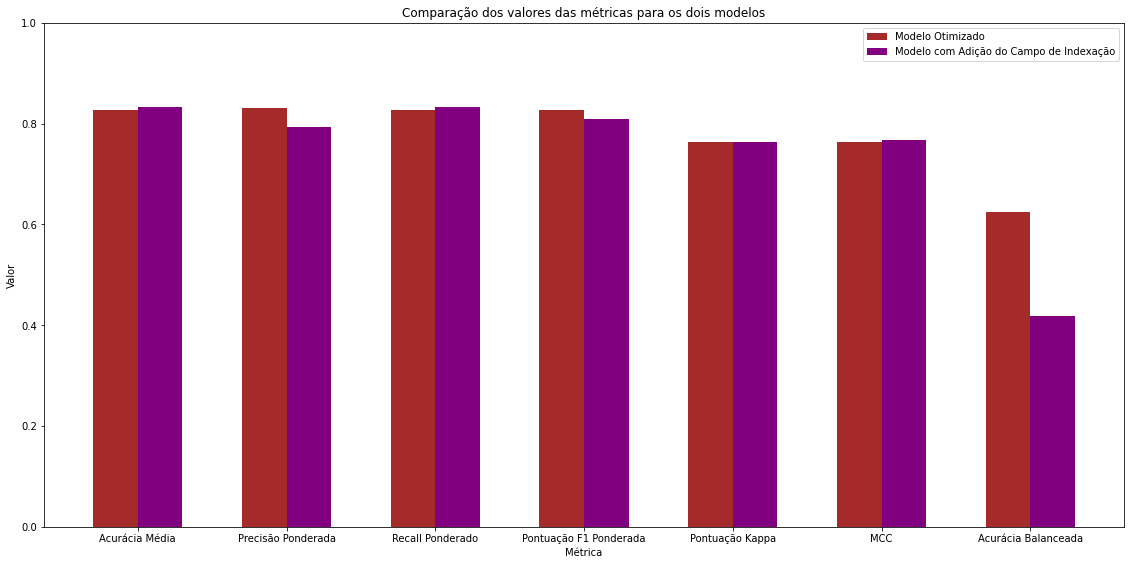

In [32]:
fig = plt.figure(figsize=(15,7))
ax = fig.add_axes([0,0,1,1])
models = ['Modelo Otimizado', 'Modelo com Adição do Campo de Indexação']
x = ['Acurácia Média', 'Precisão Ponderada', 'Recall Ponderada', 'Pontuação F1 Ponderada', 'Acurácia Balanceada', 'Pontuação Kappa', 'MCC']
y1 = [frontback_metrics['Average Accuracy'], frontback_metrics['Weighted Precision'], frontback_metrics['Weighted Recall'], frontback_metrics['Weighted F1 Score'], frontback_metrics['Cohen Kappa Score'], frontback_metrics['Matthews Correlation Coefficient'], frontback_metrics['Balanced Accuracy']]
y2 = [index_metrics['Average Accuracy'], index_metrics['Weighted Precision'], index_metrics['Weighted Recall'], index_metrics['Weighted F1 Score'], index_metrics['Cohen Kappa Score'], index_metrics['Matthews Correlation Coefficient'], index_metrics['Balanced Accuracy']]
X = np.arange(7)
ax.bar(X, y1, width=0.3, color='brown')
ax.bar(X + 0.3, y2, width=0.3, color='purple')
ax.set_title('Comparação dos valores das métricas para os dois modelos')
ax.set_ylim(top=1)
ax.set_xticks([.15, 1.15, 2.15, 3.15, 4.15, 5.15, 6.15])
ax.set_xticklabels(['Acurácia Média', 'Precisão Ponderada', 'Recall Ponderado', 'Pontuação F1 Ponderada', 'Pontuação Kappa', 'MCC', 'Acurácia Balanceada'])
ax.legend(models)
plt.xlabel('Métrica')
plt.ylabel('Valor')
plt.show()